In [337]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [346]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])

# Baseline

In [317]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X, y, cv=5)))

KeyboardInterrupt: 

# Отбор на основе ВЗАИМНОЙ ИНФОРМАЦИИ

Считаем взаимную информацию

In [347]:
mi=mutual_info_regression(X,y,n_neighbors=5,random_state=42)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Формируем список фич с низкой взаимной инфорацией

In [348]:
# Порог ВИ
mi_threshold=0.03
mi_remove_cols=list()
qty=0
# обходим все фичи
for i in range(len(mi)):
    # Если ВИ меньше порога, то добавляем признак в список для исключения
    if mi[i]<mi_threshold:
        mi_remove_cols.append('f'+str(i))
        qty=qty+1
print ('total cols to remove:',qty) 
print (mi_remove_cols)

total cols to remove: 142
['f1', 'f2', 'f3', 'f4', 'f7', 'f8', 'f9', 'f10', 'f14', 'f15', 'f16', 'f19', 'f20', 'f21', 'f24', 'f25', 'f28', 'f29', 'f31', 'f32', 'f33', 'f34', 'f35', 'f37', 'f38', 'f39', 'f40', 'f42', 'f43', 'f44', 'f45', 'f48', 'f50', 'f52', 'f53', 'f56', 'f57', 'f58', 'f60', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f71', 'f74', 'f75', 'f77', 'f80', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f90', 'f91', 'f92', 'f93', 'f95', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f104', 'f105', 'f106', 'f107', 'f110', 'f111', 'f113', 'f115', 'f117', 'f118', 'f119', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f137', 'f139', 'f140', 'f141', 'f144', 'f145', 'f146', 'f148', 'f149', 'f151', 'f153', 'f154', 'f155', 'f159', 'f160', 'f161', 'f162', 'f164', 'f165', 'f166', 'f167', 'f169', 'f172', 'f173', 'f175', 'f176', 'f177', 'f178', 'f181', 'f189', 'f190', 'f191', 'f192', 'f194', 'f195', 'f196', 'f197', 'f201', 'f202', 'f203', 'f20

Удаляем фичи с низкой взаимной инфорацией из X

In [349]:
X.drop(labels=mi_remove_cols,axis=1,inplace=True)

Считаем модель

In [277]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X, y, cv=5)))

0.573516258168


In [278]:
X.shape

(3489, 81)

Качество увеличилось

# Отбор на основе Корреляции

In [375]:
xcorr=X.corr()
corr_threshold=0.65
cor_cols=list()
for i in range(len(xcorr)):
    cor_group=list()
    for j in range(len(xcorr)):
        if j==i: continue
        if abs(xcorr.iloc[i,j])>=corr_threshold:
            #print (xcorr.index[i],xcorr.index[j],cor_val)
            if not(xcorr.index[i] in cor_group):
                cor_group.append(xcorr.index[i])
            if not(xcorr.index[j] in cor_group):
                cor_group.append(xcorr.index[j])
    if len(cor_group)>0:
        cor_group.sort()
        cor_cols.append(cor_group)
print (cor_cols)

[['f22', 'f82'], ['f22', 'f82']]


In [376]:
good_ftr=list()
bad_ftr=list()
# Удаляем дубли
for c in cor_cols:
    ftr_ser=pd.Series()
    for ftr in c:
        mi_ftr=mi[int(ftr[1:])]
        ftr_ser[ftr]=mi_ftr
    ftr_ser.sort_values(ascending=False,inplace=True)
    #print("ser")
    #print (ftr_ser.index[1:])
    bad_ftr.extend(list(ftr_ser.index[1:]))
    good_ftr.append(ftr_ser.index[0])
# Избавляемся от дубликатов
good_ftr = list(set(good_ftr))
good_ftr.sort()
bad_ftr = list(set(bad_ftr))
good_ftr.sort()
print ("Ftr with high mi=",good_ftr)
print ("Ftr to remove=",bad_ftr)

Ftr with high mi= ['f82']
Ftr to remove= ['f22']


Удаляем фичи с высокой корреляцией

In [377]:
X.drop(labels=bad_ftr,axis=1,inplace=True)

Отображаем матрицу коррелцяции после удаления фич

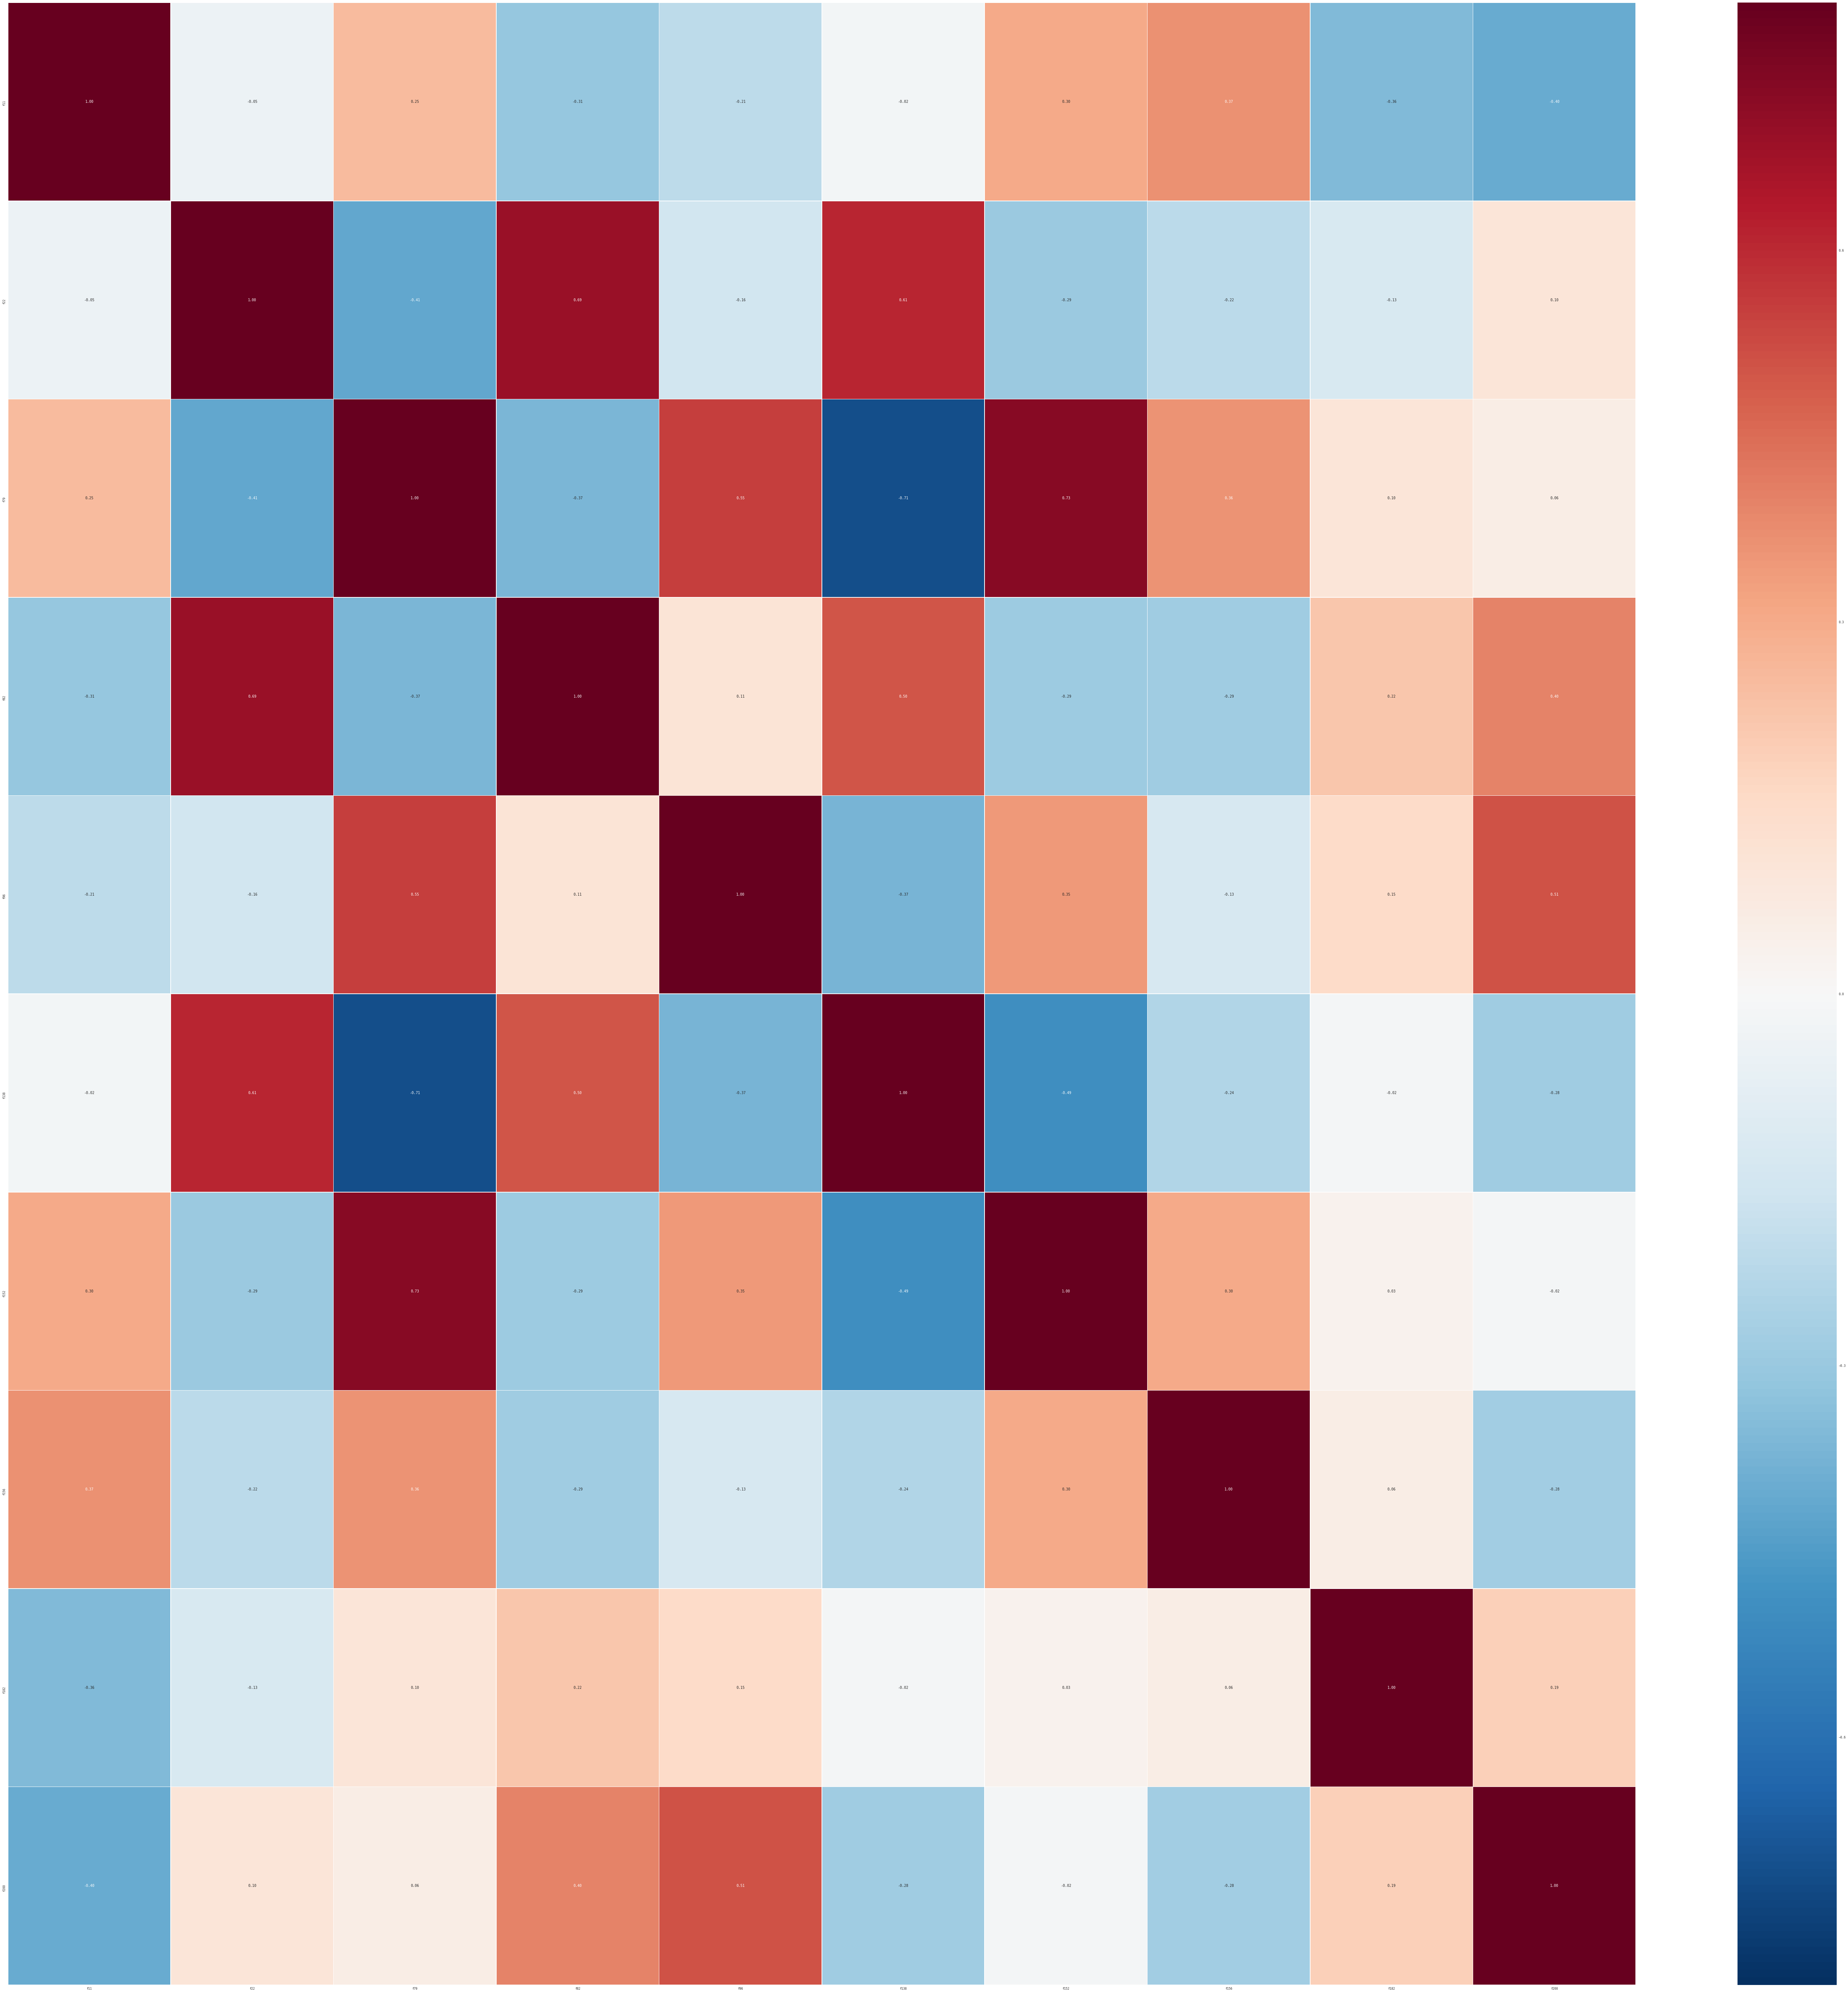

In [295]:
sns.set(context="paper", font="monospace")
plt.figure(figsize=(100, 100))
sns_heatmap = sns.heatmap(X.corr(), vmax=.8,annot=True, ffmt=".2f", linewidths=.5)
plt.show()

Строим модель 

In [378]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X, y, cv=5)))

0.614507490978


In [373]:
print(list(X.columns))
X.shape

['f11', 'f22', 'f82', 'f96', 'f138', 'f156', 'f182', 'f200']


(3489, 8)

## лучший набор фич

In [ ]:
best_cols=['f11', 'f22', 'f82', 'f96', 'f138', 'f156', 'f182', 'f200']

# Построим несколько моделей на оставшихся фичах

In [379]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X, y, cv=5)))

0.614507490978


In [380]:
def get_score(clf,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    print ("CVScore:",cv_score)
    clf.fit(X_train,y_train)
    print ("HoldOut:",clf.score(X_test,y_test))
xgbclf=xgb.XGBClassifier(max_depth=9,colsample_bytree=0.8,min_child_weight=2.0,n_estimators=326,gamma=0.8,subsample=0.5,seed=42)
get_score(xgbclf,X,y)
#CVScore: 0.529079318252
# HoldOut: 0.549188156638

CVScore: 0.572066181112
HoldOut: 0.574976122254


In [201]:
X.shape

(3489, 91)

#  recursive feature elimination.

In [389]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold

In [392]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])

Optimal number of features : 220


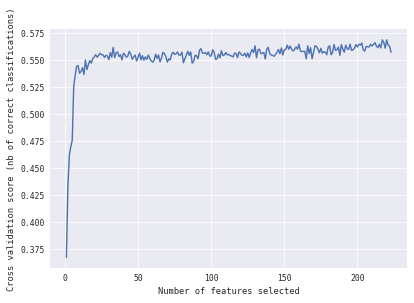

In [404]:
est = RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
rfecv = RFECV(estimator=est, step=1, cv=StratifiedKFold(5),scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [405]:
best_ftr_rfe=list(X.columns[rfecv.support_])

In [406]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X[best_ftr_rfe], y, cv=5)))

0.568923935405


In [407]:
xgbclf=xgb.XGBClassifier(max_depth=9,colsample_bytree=0.8,min_child_weight=2.0,n_estimators=326,gamma=0.8,subsample=0.5,seed=42)
get_score(xgbclf,X[best_ftr_rfe],y)

CVScore: 0.533975594372
HoldOut: 0.562559694365
